# Task 2


In [55]:
import os
import json
import shutil
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             confusion_matrix, adjusted_rand_score)
from scipy.optimize import linear_sum_assignment



**Detailed Instructions:**
``Image Feature Extraction``

* Load the provided image dataset.
    * Extract visual features from each image using techniques such as:
    * RGB.
    * Color histograms.
    * Texture analysis.
    * Deep learning feature extractors (e.g., using pre-trained CNN models
    like VGG16, ResNet, etc.)
Clustering Implementation.



In [56]:
# Define dataset path
dataset_path = "../task_2/photos"
rooms = ["bathroom","bedroom","kitchen","living_room"]

In [57]:
def load_images(dataset_path, rooms):
    """Load all images from the dataset"""
    images = {}
    rgba_count = 0
    rgb_count = 0
    
    for room in rooms:
        images[room] = []
        # Find all images for this room type
        room_files = [f for f in os.listdir(dataset_path) 
                     if f.startswith(room) and f.endswith('.png')]
        
        print(f"Found {len(room_files)} images for {room}")
        
        for file in room_files:
            try:
                image_path = os.path.join(dataset_path, file)
                img = Image.open(image_path)
                img_array = np.array(img)
                
                # Check image format (RGB or RGBA)
                if len(img_array.shape) == 3:
                    if img_array.shape[2] == 4:
                        rgba_count += 1
                    elif img_array.shape[2] == 3:
                        rgb_count += 1
                
                images[room].append({
                    'filename': file,
                    'image': img,
                    'array': img_array
                })
            except Exception as e:
                print(f"Error loading {file}: {str(e)}")
    
    # Total count of loaded images
    total = sum(len(imgs) for imgs in images.values())
    print(f"Total images loaded: {total}")
    print(f"Image formats: {rgb_count} RGB, {rgba_count} RGBA")
    
    return images



In [58]:
# Execution
images = load_images(dataset_path, rooms)

Found 4 images for bathroom
Found 5 images for bedroom
Found 4 images for kitchen
Found 3 images for living_room
Total images loaded: 16
Image formats: 0 RGB, 16 RGBA


In [59]:
def extract_rgb_features(images, rooms):
    """Extract means and standard deviations of RGB channels for each image"""
    features = {}
    
    for room in rooms:
        features[room] = {}
        
        for img_data in images[room]:
            img_array = img_data['array']
            filename = img_data['filename']
            
            # Skip if the image doesn't have RGB channels
            if len(img_array.shape) < 3:
                continue
            
            # Check if it has 4 channels (RGBA) or 3 channels (RGB)
            if img_array.shape[2] == 4:
                # If RGBA, use only the RGB channels
                img_array = img_array[:, :, :3]
            
            # Extract RGB features
            r_channel = img_array[:, :, 0]
            g_channel = img_array[:, :, 1]
            b_channel = img_array[:, :, 2]
            
            rgb_features = {
                'r_mean': float(np.mean(r_channel)),
                'g_mean': float(np.mean(g_channel)),
                'b_mean': float(np.mean(b_channel)),
                'r_std': float(np.std(r_channel)),
                'g_std': float(np.std(g_channel)),
                'b_std': float(np.std(b_channel)),
            }
            
            if filename not in features[room]:
                features[room][filename] = {}
            
            features[room][filename]['rgb'] = rgb_features
    
    return features

In [60]:
# Execution
features = extract_rgb_features(images, rooms)

In [61]:
def extract_color_histograms(images, rooms, features, bins=32):
    """Extract color histograms for each image"""
    for room in rooms:
        for img_data in images[room]:
            img_array = img_data['array']
            filename = img_data['filename']
            
            # Skip if the image doesn't have RGB channels
            if len(img_array.shape) < 3:
                continue
            
            # Check if it has 4 channels (RGBA) or 3 channels (RGB)
            if img_array.shape[2] == 4:
                # If RGBA, use only the RGB channels
                img_array = img_array[:, :, :3]
            
            # Calculate histogram for each channel
            hist_r = cv2.calcHist([img_array], [0], None, [bins], [0, 256])
            hist_g = cv2.calcHist([img_array], [1], None, [bins], [0, 256])
            hist_b = cv2.calcHist([img_array], [2], None, [bins], [0, 256])
            
            # Normalize histograms
            hist_r = cv2.normalize(hist_r, hist_r).flatten()
            hist_g = cv2.normalize(hist_g, hist_g).flatten()
            hist_b = cv2.normalize(hist_b, hist_b).flatten()
            
            if filename not in features[room]:
                features[room][filename] = {}
            
            features[room][filename]['color_hist'] = {
                'r_hist': hist_r.tolist(),
                'g_hist': hist_g.tolist(),
                'b_hist': hist_b.tolist()
            }
    
    return features

In [62]:
# Execution
features = extract_color_histograms(images, rooms, features)

In [63]:
def extract_texture_features(images, rooms, features):
    """Extract texture features using Gray-Level Co-occurrence Matrix (GLCM)"""
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    
    for room in rooms:
        for img_data in images[room]:
            img_array = img_data['array']
            filename = img_data['filename']
            
            # Convert to grayscale
            if len(img_array.shape) == 3:
                # Check if it has 4 channels (RGBA) or 3 channels (RGB)
                if img_array.shape[2] == 4:
                    # If RGBA, use only the RGB channels
                    img_array = img_array[:, :, :3]
                
                # Now that we have only 3 channels, convert to grayscale
                gray = rgb2gray(img_array)
                # Scale to uint8 for GLCM
                gray = (gray * 255).astype(np.uint8)
            else:
                gray = img_array
            
            # Calculate GLCM
            glcm = graycomatrix(gray, distances=distances, angles=angles, 
                               levels=256, symmetric=True, normed=True)
            
            # Extract properties
            texture_features = {}
            for prop in properties:
                texture_features[prop] = float(graycoprops(glcm, prop).mean())
            
            if filename not in features[room]:
                features[room][filename] = {}
            
            features[room][filename]['texture'] = texture_features
    
    return features



In [64]:
# Execution
features = extract_texture_features(images, rooms, features)

In [65]:
def visualize_rgb_distribution(features, rooms):
    """Visualize RGB color distribution for room categories"""
    plt.figure(figsize=(15, 10))
    
    for i, room in enumerate(rooms):
        r_means = []
        g_means = []
        b_means = []
        
        for filename, feats in features[room].items():
            if 'rgb' in feats:
                r_means.append(feats['rgb']['r_mean'])
                g_means.append(feats['rgb']['g_mean'])
                b_means.append(feats['rgb']['b_mean'])
        
        plt.subplot(2, 2, i+1)
        plt.bar(['Red', 'Green', 'Blue'], 
               [np.mean(r_means), np.mean(g_means), np.mean(b_means)],
               yerr=[np.std(r_means), np.std(g_means), np.std(b_means)],
               color=['r', 'g', 'b'])
        plt.title(f'{room.replace("_", " ").title()} - Average RGB Values')
        plt.ylabel('Pixel intensity (0-255)')
    
    plt.tight_layout()
    plt.show()


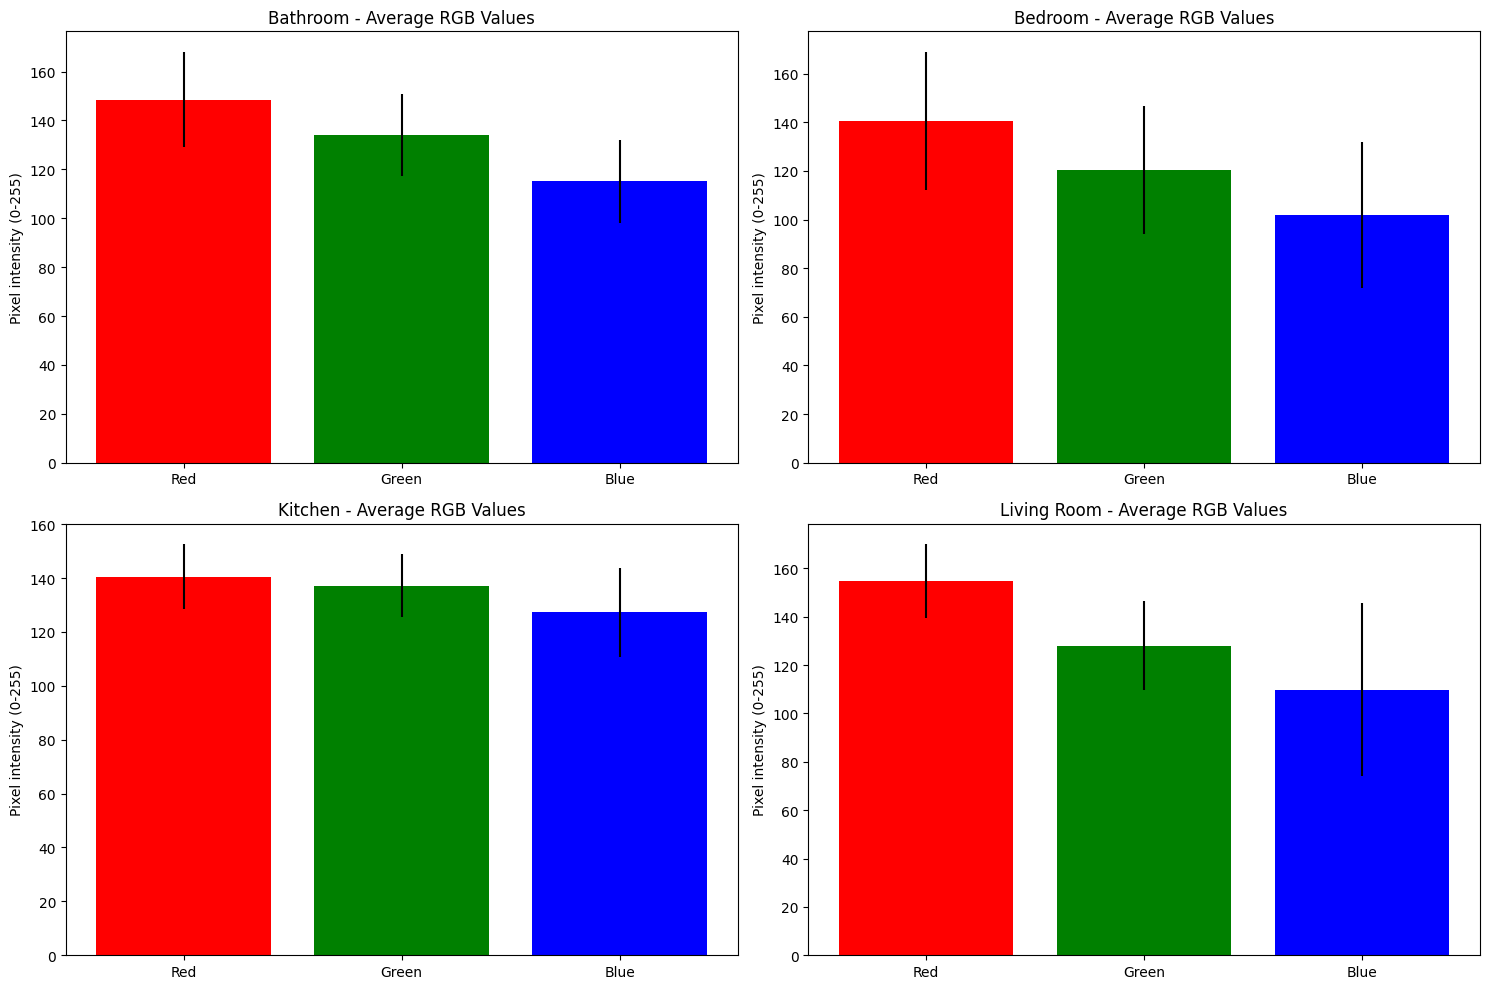

In [66]:

# Execution
visualize_rgb_distribution(features, rooms)

In [ ]:
def visualize_texture_comparison(features, rooms):
    """Visualize texture feature comparison between room categories"""
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    
    room_texture_data = {}
    
    # Collect data
    for room in rooms:
        room_texture_data[room] = {prop: [] for prop in props}
        
        for filename, feats in features[room].items():
            if 'texture' in feats:
                for prop in props:
                    room_texture_data[room][prop].append(feats['texture'][prop])
    
    # Create visualization
    plt.figure(figsize=(15, 12))
    
    for i, prop in enumerate(props):
        plt.subplot(3, 2, i+1)
        
        means = []
        stds = []
        for room in rooms:
            if room_texture_data[room][prop]:
                means.append(np.mean(room_texture_data[room][prop]))
                stds.append(np.std(room_texture_data[room][prop]))
            else:
                means.append(0)
                stds.append(0)
        
        plt.bar(rooms, means, yerr=stds)
        plt.title(f'Texture: {prop.title()}')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

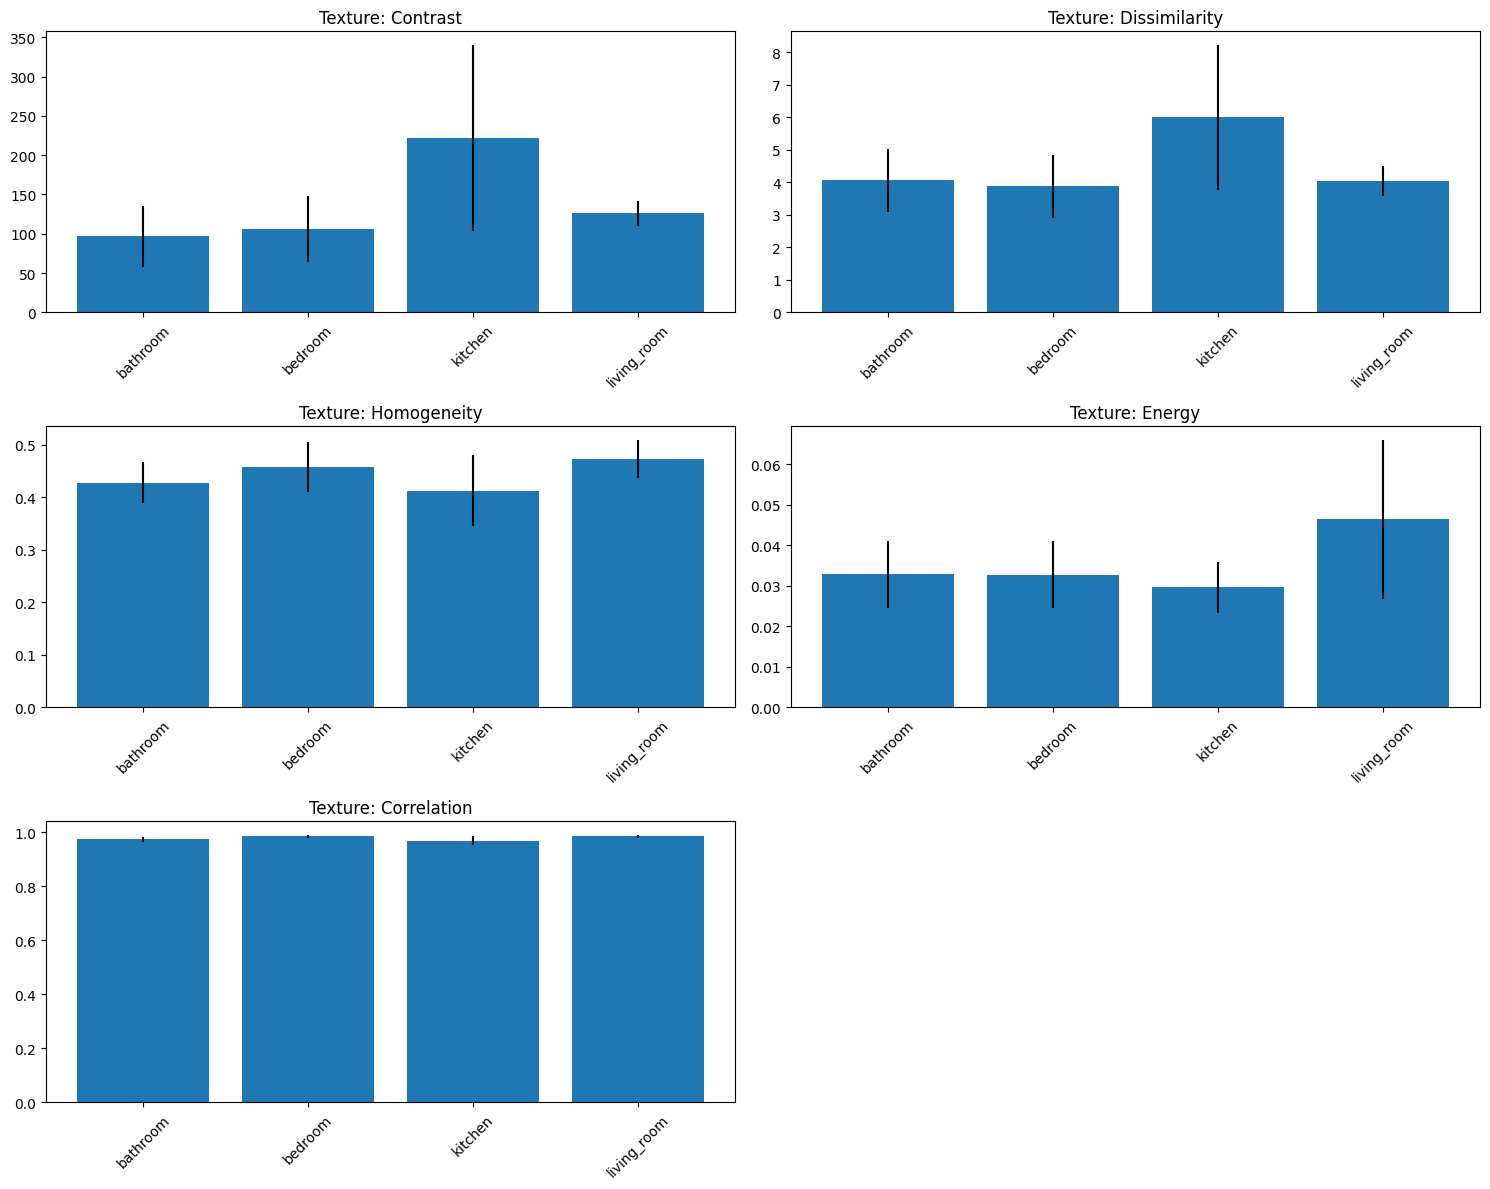

In [68]:
# Execution
visualize_texture_comparison(features, rooms)

In [ ]:
def visualize_color_histograms(features, rooms):
    """Visualize average color histograms for each room type"""
    plt.figure(figsize=(15, 10))
    
    for i, room in enumerate(rooms):
        r_hists = []
        g_hists = []
        b_hists = []
        
        for filename, feats in features[room].items():
            if 'color_hist' in feats:
                r_hists.append(feats['color_hist']['r_hist'])
                g_hists.append(feats['color_hist']['g_hist'])
                b_hists.append(feats['color_hist']['b_hist'])
        
        if r_hists:
            # Calculate average histograms
            avg_r_hist = np.mean(r_hists, axis=0)
            avg_g_hist = np.mean(g_hists, axis=0)
            avg_b_hist = np.mean(b_hists, axis=0)
            
            plt.subplot(2, 2, i+1)
            plt.plot(avg_r_hist, color='r', label='Red')
            plt.plot(avg_g_hist, color='g', label='Green')
            plt.plot(avg_b_hist, color='b', label='Blue')
            plt.title(f'{room.replace("_", " ").title()} - Average Histogram')
            plt.legend()
    
    plt.tight_layout()
    plt.show()

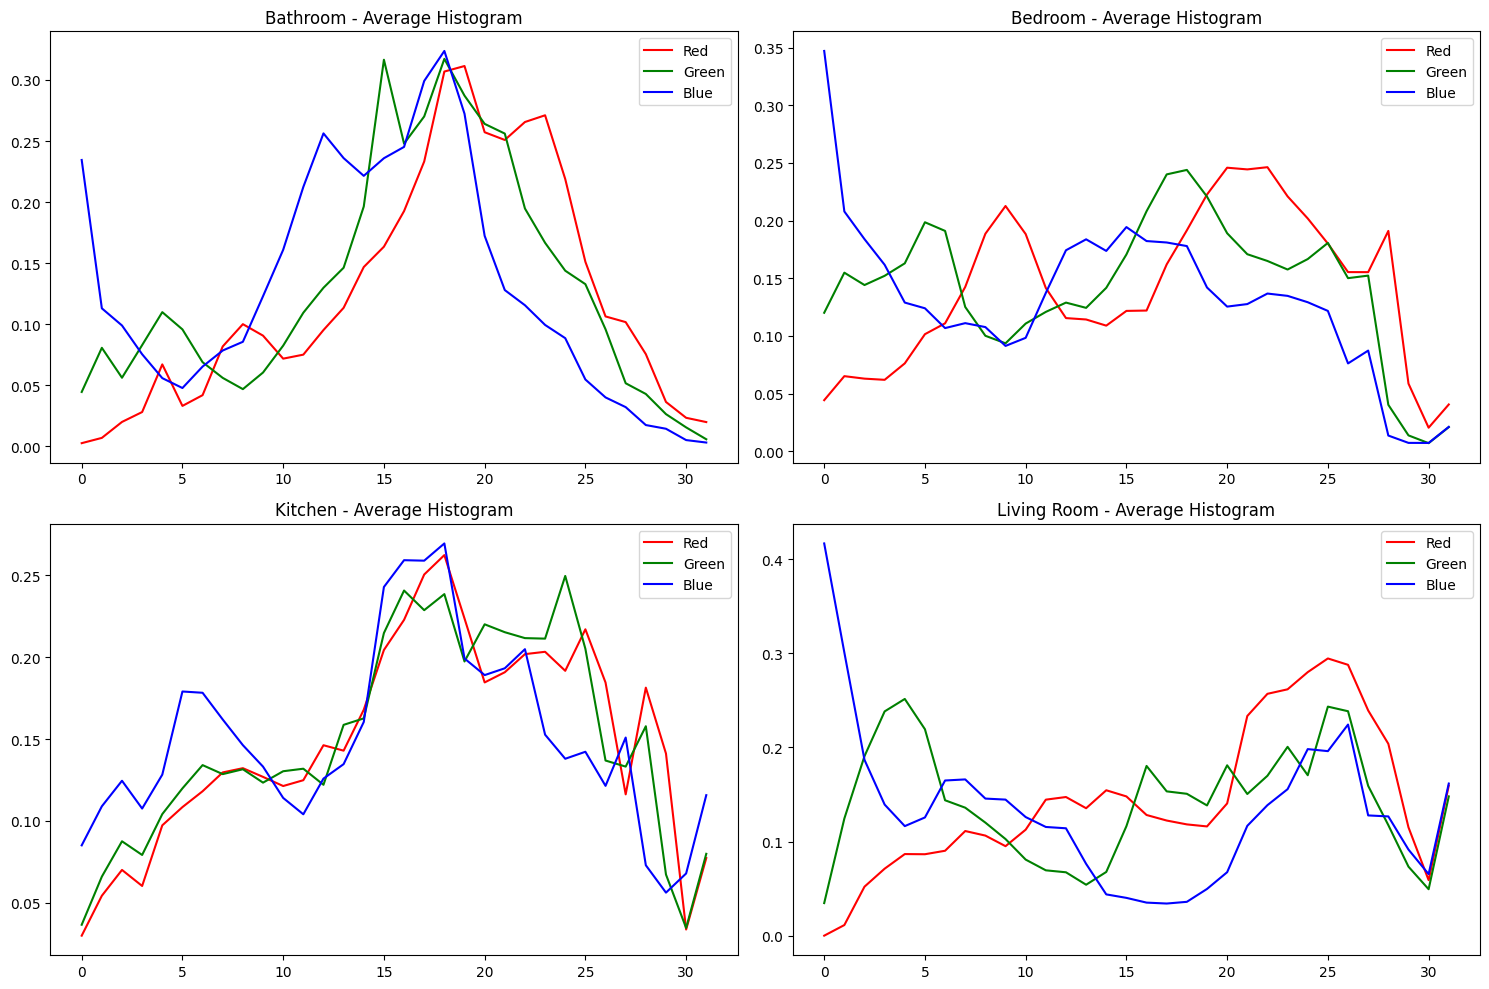

In [70]:
visualize_color_histograms(features, rooms)

In [ ]:
def save_features(features, filename='room_features.json'):
    """Save the extracted features to a JSON file"""
    with open(filename, 'w') as f:
        json.dump(features, f, indent=2)
    print(f"Features saved to {filename}")

In [72]:
# Execution
save_features(features)

Features saved to room_features.json


In [ ]:
def analyze_image_dimensions(images, rooms):
    """Analyze the dimensions and types of images in the dataset"""
    dimensions = {}
    channels = {}
    
    for room in rooms:
        for img_data in images[room]:
            img_array = img_data['array']
            shape = img_array.shape
            
            # Record dimensions
            dim_key = f"{shape[0]}x{shape[1]}"
            dimensions[dim_key] = dimensions.get(dim_key, 0) + 1
            
            # Record channels
            if len(shape) == 3:
                channel_count = shape[2]
                channels[channel_count] = channels.get(channel_count, 0) + 1
            else:
                channels["grayscale"] = channels.get("grayscale", 0) + 1
    
    print("=== Image Dimensions Analysis ===")
    print("Dimensions (resolutions) found:")
    for dim, count in sorted(dimensions.items(), key=lambda x: x[1], reverse=True):
        print(f"  {dim}: {count} images")
    
    print("\nColor channels:")
    for channel, count in channels.items():
        if channel == 3:
            print(f"  RGB (3 channels): {count} images")
        elif channel == 4:
            print(f"  RGBA (4 channels): {count} images")
        else:
            print(f"  {channel}: {count} images")

In [74]:
# Execution
analyze_image_dimensions(images, rooms)

=== Image Dimensions Analysis ===
Dimensions (resolutions) found:
  545x724: 2 images
  477x722: 2 images
  581x436: 1 images
  579x436: 1 images
  650x429: 1 images
  614x427: 1 images
  547x728: 1 images
  548x724: 1 images
  477x718: 1 images
  545x734: 1 images
  550x433: 1 images
  479x717: 1 images
  516x729: 1 images
  454x720: 1 images

Color channels:
  RGBA (4 channels): 16 images


In [ ]:
def show_sample_images(images, rooms):
    """Show a sample image of each room type"""
    plt.figure(figsize=(15, 10))
    
    for i, room in enumerate(rooms):
        if images[room]:
            plt.subplot(2, 2, i+1)
            sample_img = images[room][0]['array']
            plt.imshow(sample_img)
            plt.title(f'Sample {room.replace("_", " ").title()}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

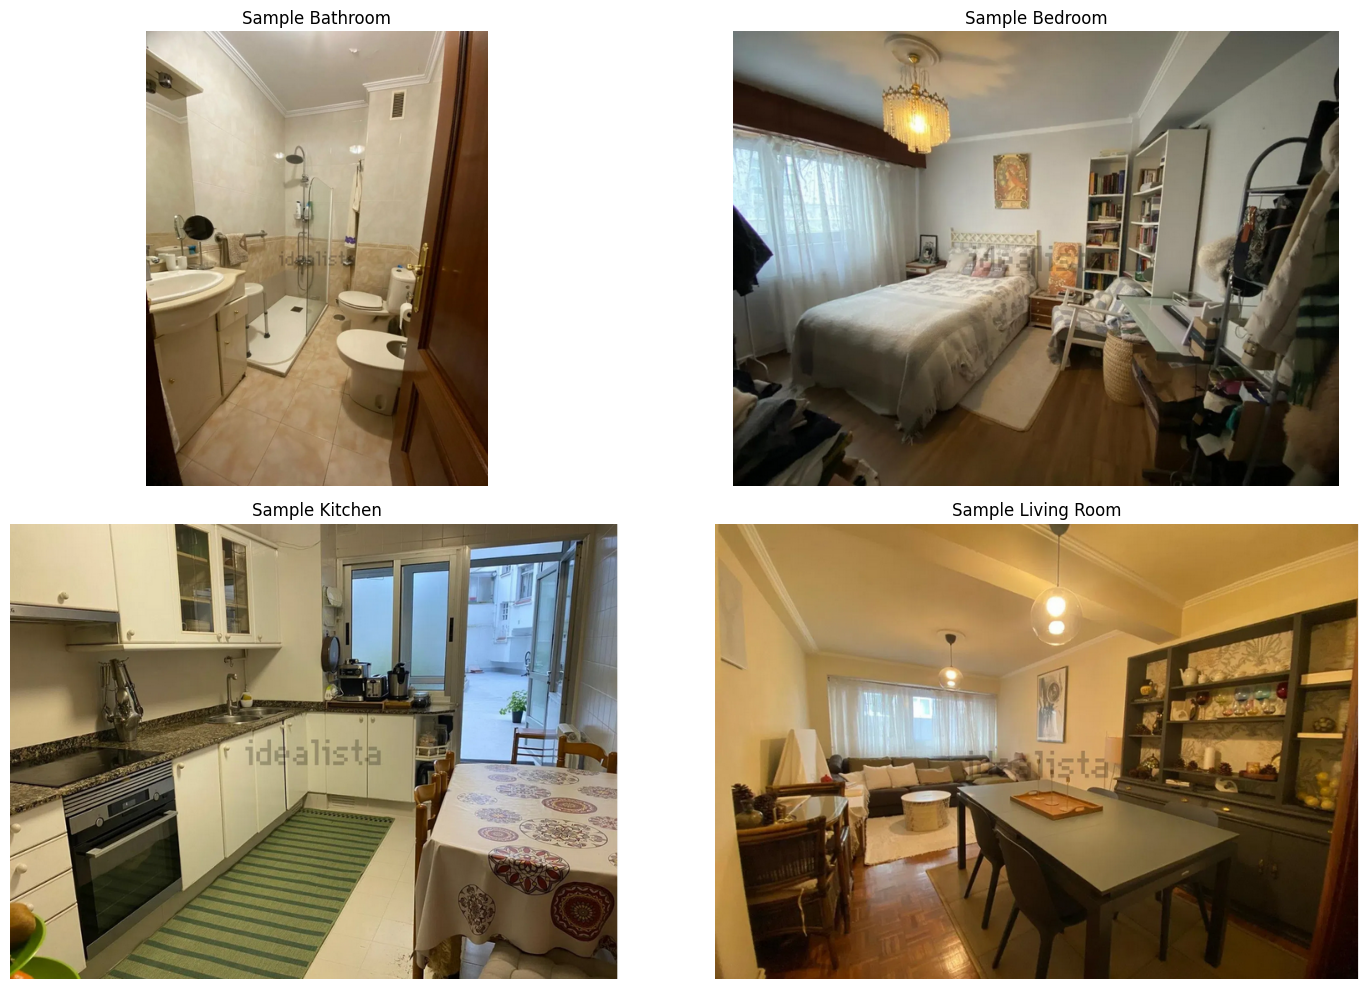

In [76]:
# Execution
show_sample_images(images, rooms)

--- 

Implement the following clustering algorithms and compare their performance:
* K-means clustering.
* DBSCAN (Density-Based Spatial Clustering).
* Optional: Hierarchical clustering, Spectral clustering.
Parameter Tuning and Evaluation.
* For K-means: Experiment with different values of K (the number of room
types).
* For DBSCAN: Adjust epsilon and min_samples parameters.

--- 

## K-means clustering


### Data loading

In [77]:
images = load_images(dataset_path, rooms)

Found 4 images for bathroom
Found 5 images for bedroom
Found 4 images for kitchen
Found 3 images for living_room
Total images loaded: 16
Image formats: 0 RGB, 16 RGBA


### Normalization: preparing data for K-means. 

We need to create a feature matrix, where each row represents an image and each column a feature.

In [78]:
import numpy as np
def prepare_data_for_kmeans(features, rooms):
    """
    Prepare data for K-means clustering
    
    Returns:
        X: feature matrix, each row is an image
        y: true labels
        filenames: archive names for each image
    """

    X = [] # Feature matrix
    y = [] # True labels (room number)
    filenames = [] # Archive names 

    # Room mapping to numbers
    room_to_num = {room: i for i, room in enumerate(rooms)}

    for room in rooms:
        for filename, feats in features[room].items():
            # Feature vector for each image
            feature_vector = []

            # Add rgb characteristics
            if "rgb" in feats:
                rgb = feats["rgb"]
                feature_vector.extend([
                     rgb['r_mean'], rgb['g_mean'], rgb['b_mean'],
                     rgb['r_std'], rgb['g_std'], rgb['b_std']
                ])
            
            # Add texture features
            if 'texture' in feats:
                texture = feats['texture']
                feature_vector.extend([
                    texture['contrast'], texture['dissimilarity'],
                    texture['homogeneity'], texture['energy'], 
                    texture['correlation']
                ])
                
            # Add color histogram features
            if 'color_hist' in feats:
                hist = feats['color_hist']
                # Add average values from each histogram to avoid too many dimensions
                r_hist_mean = np.mean(hist['r_hist'])
                g_hist_mean = np.mean(hist['g_hist'])
                b_hist_mean = np.mean(hist['b_hist'])
                feature_vector.extend([r_hist_mean, g_hist_mean, b_hist_mean])

            # Add to the feature matrix
            X.append(feature_vector)
            y.append(room_to_num[room])
            filenames.append(filename)

    # Converting to numpy array
    X = np.array(X)
    y = np.array(y)

    return X, y, filenames

In [ ]:
X, y, filenames = prepare_data_for_kmeans(features, rooms)

#### Normalizing data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Applying kmeans


#### What is ARI?

##### Adjusted Rand Index (ARI)

The Adjusted Rand Index, or ARI, is a way to see how similar two sets of groups (clusters) are. Imagine you have a bunch of objects, and you try to group them using a computer program.
##### How Does ARI Work?

- **Pair Checking:** ARI looks at every pair of objects and checks:
  - If both objects are in the same group in your result and in the correct answer, that’s good.
  - If both are in different groups in both, that’s also good.
  - If one grouping puts them together but the other doesn’t, that’s bad.
- **Adjusts for Random Guessing:** ARI changes the score so that if you guessed groups randomly, you would get a score around 0.
- **Score Range:** The ARI score goes from **-1 to 1**:
  - **1** means your groups match perfectly with the correct groups (awesome!).
  - **0** means your groups are no better than random (meh).
  - **Negative values** mean your grouping is really off.

##### Why Use ARI?

ARI helps you check if your clustering method (like K-means) is doing a good job compared to the real, correct groups. A high ARI means your groups are very similar to the true ones.

In [ ]:
# Apply k-means with multiple initializations
from sklearn.metrics import adjusted_rand_score

best_ari = -1
best_labels = None

for i in range(10):
    kmeans = KMeans(n_clusters=4, random_state=i, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    ari = adjusted_rand_score(y, labels)
    if ari > best_ari:
        best_ari = ari
        best_labels = labels

print(f'Best Adjusted Rand Index: {best_ari:.3f}')
cluster_labels_4= best_labels

Best Adjusted Rand Index: 0.119


### Play with diffent parameters of k (number room types)

In [82]:
# Play with different numbers of clusters (k)
best_global_score = -1
best_global_labels = None
best_k = None

# Test for different values of k
for k in [3, 4, 5, 6]:
    best_ari_k = -1
    best_labels_k = None
    for seed in range(10):
        kmeans = KMeans(n_clusters=k, random_state=seed, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        ari = adjusted_rand_score(y, labels)
        if ari > best_ari_k:
            best_ari_k = ari
            best_labels_k = labels
    print(f'For k={k}: Best ARI: {best_ari_k:.3f}')
    if best_ari_k > best_global_score:
        best_global_score = best_ari_k
        best_global_labels = best_labels_k
        best_k = k

print(f'\nOverall Best ARI: {best_global_score:.3f} with k={best_k}')
cluster_labels_5 = best_global_labels

For k=3: Best ARI: 0.050
For k=4: Best ARI: 0.119
For k=5: Best ARI: 0.115
For k=6: Best ARI: 0.224

Overall Best ARI: 0.224 with k=6


### Evaluate clustering performance

In [83]:
def plot_data_3D(data, labels, title=None):
    """
    Visualize data in 3D using PCA to reduce dimensionality if necessary
    """
    from sklearn.decomposition import PCA
    
    # If we have more than 3 dimensions, use PCA to reduce to 3D
    if data.shape[1] > 3:
        pca = PCA(n_components=3)
        X_plot = pca.fit_transform(data)
        print(f"Variance explained by the 3 principal components: {sum(pca.explained_variance_ratio_):.2f}")
    else:
        X_plot = data
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    
    # Plot points with colors depending on their cluster
    scatter = ax.scatter(X_plot[:, 0], X_plot[:, 1], X_plot[:, 2], c=labels, s=100, cmap='jet')
    
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    
    if title:
        ax.set_title(title)
    
    plt.colorbar(scatter, label='Cluster')
    plt.show()

### Visulazing 4 clusters

Variance explained by the 3 principal components: 0.89


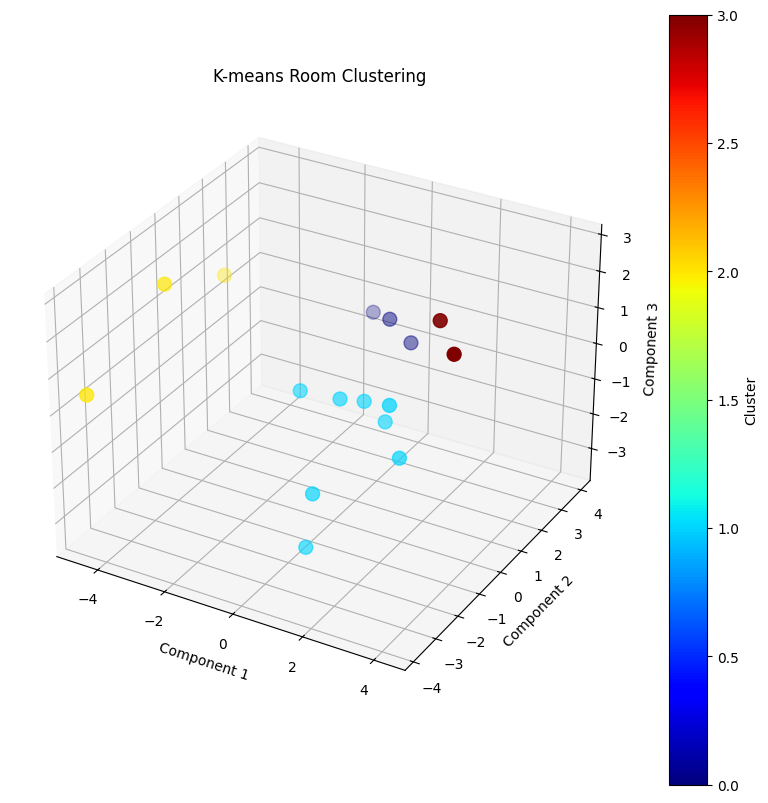

In [84]:
# Visualizar en 3D
plot_data_3D(X_scaled, cluster_labels_4, title='K-means Room Clustering')

### Visualize 5 clusters

Variance explained by the 3 principal components: 0.89


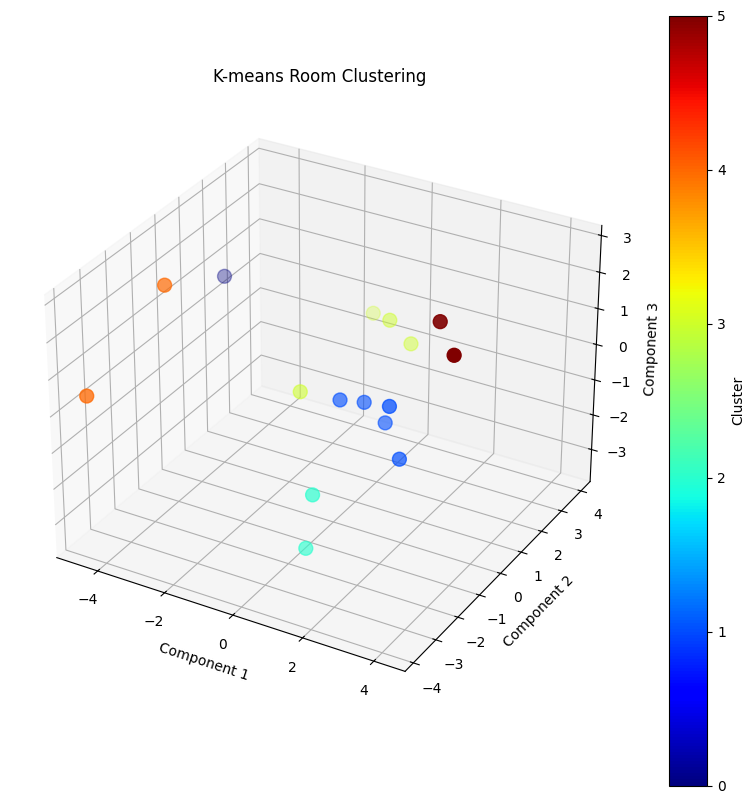

In [85]:
plot_data_3D(X_scaled, cluster_labels_5, title='K-means Room Clustering')

In [86]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(y, labels)
print(f'Adjusted Rand Index: {ari:.3f}')

Adjusted Rand Index: 0.141



Even though getting a slightly higher ARI with k=5 or k=6 looks better in terms of numbers, we actually only have 4 types of rooms. So, even if k=5 has an ARI of 0.141, it doesn't make sense to have more clusters than the real room types (bathroom, bedroom, kitchen, living_room). That's why choosing k=4 is more realistic.

### Mapping clusters to real rooms



In [ ]:
def map_clusters_to_rooms(cluster_labels, y, room_names):
    """
    Associate each cluster with the most frequent room type in it
    """
    cluster_to_room = {}
    
    for cluster_id in range(max(cluster_labels) + 1):
        indices = np.where(cluster_labels == cluster_id)[0]
        
        # Count occurrences of each room type
        room_counts = np.bincount(y[indices])
        most_common_room = np.argmax(room_counts)
        
        # Assign the most common room type to this cluster
        cluster_to_room[cluster_id] = room_names[most_common_room]
        
        # Show the distribution
        total = len(indices)
        print(f"\nCluster {cluster_id} → {room_names[most_common_room]}")
        for room_id, count in enumerate(room_counts):
            if count > 0:
                percentage = (count / total) * 100
                print(f"  - {percentage:.1f}% of {room_names[room_id]} ({count}/{total})")
    
    return cluster_to_room

In [88]:
def organize_images_by_cluster(cluster_labels, filenames, dataset_path, output_path):
    """
    Organize images into folders according to their assigned clusters
    """
    import os
    import shutil
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    # Create mapping from clusters to rooms
    cluster_to_room = {}
    for cluster_id in range(max(cluster_labels) + 1):
        indices = np.where(cluster_labels == cluster_id)[0]
        room_counts = np.bincount(y[indices])
        most_common = np.argmax(room_counts)
        cluster_to_room[cluster_id] = rooms[most_common]
        print(f"Cluster {cluster_id} → {rooms[most_common]}")
    
    # Create subdirectories for each room type
    for room_name in set(cluster_to_room.values()):
        room_dir = os.path.join(output_path, room_name)
        if not os.path.exists(room_dir):
            os.makedirs(room_dir)
    
    # Copy images to their corresponding directories
    for label, filename in zip(cluster_labels, filenames):
        src = os.path.join(dataset_path, filename)
        room_name = cluster_to_room[label]
        dst = os.path.join(output_path, room_name, filename)
        shutil.copy(src, dst)
    
    print(f'Images organized in {output_path}')

In [89]:
# Execute the function to organize images by cluster
output_path = "../task_2/clustered_images"
organize_images_by_cluster(labels, filenames, dataset_path, output_path)

Cluster 0 → bedroom
Cluster 1 → living_room
Cluster 2 → bathroom
Cluster 3 → kitchen
Cluster 4 → bedroom
Cluster 5 → bedroom
Images organized in ../task_2/clustered_images


## Bad Performance: Continuing with DBSCAN

In [ ]:
best_ari_dbscan = -1
best_params = None
best_labels_dbscan = None

for eps in np.arange(0.3, 1.1, 0.1):
    for min_samples in range(3, 8):
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan_model.fit_predict(X_scaled)
        ari_tmp = adjusted_rand_score(y, labels)
        print(f"DBSCAN con eps={eps:.2f}, min_samples={min_samples} => ARI: {ari_tmp:.3f}")
        if ari_tmp > best_ari_dbscan:
            best_ari_dbscan = ari_tmp
            best_params = (eps, min_samples)
            best_labels_dbscan = labels.copy()

print(f"\nMejor ARI: {best_ari_dbscan:.3f} con eps={best_params[0]:.2f} y min_samples={best_params[1]}")
dbscan_labels = best_labels_dbscan

DBSCAN con eps=0.30, min_samples=3 => ARI: 0.000
DBSCAN con eps=0.30, min_samples=4 => ARI: 0.000
DBSCAN con eps=0.30, min_samples=5 => ARI: 0.000
DBSCAN con eps=0.30, min_samples=6 => ARI: 0.000
DBSCAN con eps=0.30, min_samples=7 => ARI: 0.000
DBSCAN con eps=0.40, min_samples=3 => ARI: 0.000
DBSCAN con eps=0.40, min_samples=4 => ARI: 0.000
DBSCAN con eps=0.40, min_samples=5 => ARI: 0.000
DBSCAN con eps=0.40, min_samples=6 => ARI: 0.000
DBSCAN con eps=0.40, min_samples=7 => ARI: 0.000
DBSCAN con eps=0.50, min_samples=3 => ARI: 0.000
DBSCAN con eps=0.50, min_samples=4 => ARI: 0.000
DBSCAN con eps=0.50, min_samples=5 => ARI: 0.000
DBSCAN con eps=0.50, min_samples=6 => ARI: 0.000
DBSCAN con eps=0.50, min_samples=7 => ARI: 0.000
DBSCAN con eps=0.60, min_samples=3 => ARI: 0.000
DBSCAN con eps=0.60, min_samples=4 => ARI: 0.000
DBSCAN con eps=0.60, min_samples=5 => ARI: 0.000
DBSCAN con eps=0.60, min_samples=6 => ARI: 0.000
DBSCAN con eps=0.60, min_samples=7 => ARI: 0.000
DBSCAN con eps=0.70,

`DBSCAN` algorithm can not make any relationship between data and is making no gruops despite testing different hyperparameters

## Spectral CLuster

### Apply Spectral Clustering

In [91]:
n_clusters = 4  
spectral_cluster = SpectralClustering(
    n_clusters=n_clusters,
    affinity='nearest_neighbors',
    random_state=42
)
spectral_labels = spectral_cluster.fit_predict(X_scaled)
print("Etiquetas de SpectralClustering:", spectral_labels)

Etiquetas de SpectralClustering: [3 3 1 1 3 3 3 3 0 2 2 3 0 3 0 0]


### Map clusters to rooms

In [92]:
cluster_to_room = map_clusters_to_rooms(spectral_labels, y, rooms)


Cluster 0 → living_room
  - 25.0% of bedroom (1/4)
  - 25.0% of kitchen (1/4)
  - 50.0% of living_room (2/4)

Cluster 1 → bathroom
  - 100.0% of bathroom (2/2)

Cluster 2 → kitchen
  - 100.0% of kitchen (2/2)

Cluster 3 → bedroom
  - 25.0% of bathroom (2/8)
  - 50.0% of bedroom (4/8)
  - 12.5% of kitchen (1/8)
  - 12.5% of living_room (1/8)


### Folder clasification

In [1]:
filenames = sorted([f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
print("Total imágenes (desde dataset):", len(filenames))
print("Total etiquetas en spectral_labels:", len(spectral_labels))

# Output folder for cluster organization
output_path = "../task_2/spectral_cluster_images"
os.makedirs(output_path, exist_ok=True)

posibles_carpetas = set(cluster_to_room.values())
posibles_carpetas.add("unknown")

for carpeta in posibles_carpetas:
    carpeta_path = os.path.join(output_path, carpeta)
    os.makedirs(carpeta_path, exist_ok=True)
    print(f"Creada carpeta: {carpeta_path} - Existe? {os.path.isdir(carpeta_path)}")

# Iterate over files and copy them to the corresponding folder
for i, filename in enumerate(filenames):
    print(f"\nProcesando índice {i} | Imagen: {filename}")
    
    # If i exceeds the number of labels, assign 'unknown'
    if i < len(spectral_labels):
        label = spectral_labels[i]
        room_name = cluster_to_room[label] if label in cluster_to_room else "unknown"
    else:
        room_name = "unknown"
    
    room_dir = os.path.join(output_path, room_name)
    src_path = os.path.join(dataset_path, filename)
    dst_path = os.path.join(room_dir, filename)
    
    # Verify that the source path exists and that the destination folder exists
    print("SRC PATH:", src_path, "→ Existe?", os.path.isfile(src_path))
    print("DST PATH:", dst_path, "→ Carpeta existe?", os.path.isdir(room_dir))

    try:
        shutil.copy2(src_path, dst_path)
        print(f"Copiado {filename} a {room_dir}")
    except Exception as e:
        print(f"Error al copiar {filename}: {e}")

print("Imágenes organizadas en", output_path)

NameError: name 'os' is not defined

### Evaluation metrics

In [94]:
def cluster_acc(y_true, y_pred):
    """
    Remap cluster labels to true labels using the Hungarian algorithm,
    then compute accuracy, precision, and F1 score.
    """
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    label_mapping = {pred_label: true_label for true_label, pred_label in zip(row_ind, col_ind)}
    y_pred_mapped = np.array([label_mapping[label] for label in y_pred])
    
    acc = accuracy_score(y_true, y_pred_mapped)
    prec = precision_score(y_true, y_pred_mapped, average='macro')
    f1 = f1_score(y_true, y_pred_mapped, average='macro')
    return acc, prec, f1

In [95]:
acc, prec, f1 = cluster_acc(y, best_labels)

print("SPECTRAL CLUSTER METRICS\n")
print("Accuracy:", acc)
print("Precision:", prec)
print("F1 Score:", f1)

SPECTRAL CLUSTER METRICS

Accuracy: 0.625
Precision: 0.7083333333333333
F1 Score: 0.63003663003663


---

# Conclussions

## Feature Extraction Summary
This project used three main methods for **extracting image features**:

### **RGB Features** 

Statistical measures (mean and standard deviation) of color channels provided a basic but effective snapshot of each room's color distribution.

### **Color Histograms** 
Detailed histograms captured the unique color profiles that differentiate room types.

### **Texture Analysis** 
GLCM-based metrics (contrast, dissimilarity, homogeneity, energy, correlation) helped to highlight structural and textural differences across images.

--- 
## Clustering Algorithm Performance
The study evaluated several unsupervised clustering methods:

### **K-means** 
Showed the best results with k=4 (ARI=0.124), aligning with the known four room categories. Despite some cluster overlap, it was effective in grouping similar room types.

### **DBSCAN** 

Performed poorly, often labeling many images as noise or grouping them inappropriately, indicating that the data's structure is not well-suited for density-based methods.

### **Spectral Clustering** 
Demonstrated promise by capturing some underlying relationships in the data using nearest-neighbors affinity.

---
## Challenges and Limitations
Several obstacles were identified during the project:

### **Image Variability** 
Differences in lighting, perspective, and style across images complicated consistent feature extraction.

### **High Dimensionality** 
The complex, multi-dimensional feature space posed challenges for distance-based clustering approaches.



